# Debugging `Loss_PDE` for the Poisson Equation

This notebook is designed to help debug the `Loss_PDE` class, specifically its usage with `Poisson_loss` for the 'poisson' dataset as seen in `TrainPINO_CNO.py`.

## 1. Setup

First, we import the necessary libraries and add the project's root directory to the system path to ensure all modules can be found.

In [41]:
import sys
import os
import torch
import pandas as pd
import json
import matplotlib.pyplot as plt

# Add parent directory to path to import project modules
if '..' not in sys.path:
    sys.path.append('..')

from Problems.CNOBenchmarks import SinFrequency
from Physics_NO.loss_functions.ModulePDELoss import Loss_PDE, Poisson_loss, Laplace, Unnormalize

## 2. Configuration and Parameters

We'll define the parameters for our debugging session. These are taken directly from `TrainPINO_CNO.py` for the Poisson example. We'll load a pretrained model as specified in the script.

In [42]:
InfoPretrainedNetwork = {
    "Path to pretrained model": "../TrainedModels/PINO_CNO_pretrainedpoisson", 
    "Pretrained Samples":  1024,
}

training_properties = {
    "learning_rate": 0.0003, 
    "weight_decay": 1e-10,
    "scheduler_step": 10,
    "scheduler_gamma": 0.98,
    "epochs": 100,
    "batch_size": 16,
    "exp": 1, # L1 error
    "training_samples": 1024,
    "pde_decay": 1,
    "boundary_decay": 1,
    "pad_factor": 0
}

which_example = 'poisson'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Load Data and Model

In [43]:
# Load model architecture from the pretrained model's directory
net_architecture_path = os.path.join(InfoPretrainedNetwork["Path to pretrained model"], 'net_architecture.txt')
df = pd.read_csv(net_architecture_path, header=None, index_col=0)
model_architecture_ = df.to_dict()[1]
model_architecture_ = {key: int(value) if str(value).isdigit() else float(value) if '.' in str(value) else value for key, value in df.to_dict()[1].items()}
in_size = model_architecture_["in_size"]

# Load data
example = SinFrequency(model_architecture_, device, batch_size=training_properties['batch_size'], training_samples=training_properties['training_samples'])
train_loader = example.train_loader

# Get normalization values from dataset
Normalization_values = train_loader.dataset.get_max_and_min()

# Load model
pretrained_model_path = os.path.join(InfoPretrainedNetwork["Path to pretrained model"], 'model.pkl')
model = torch.load(pretrained_model_path, map_location=device, weights_only=False)
if hasattr(model, 'device'):
    model.device = device
model = model.to(device)
model.eval()

print("Model and data loaded successfully.")

in_size: 64
type(in_size): <class 'int'>
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
Model and data loaded successfully.


/cluster/home/lkellijs/pino/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Replicating the Training Loop's Loss Calculation

Now we get a single batch of data, pass it through the model, and calculate the loss, just as it happens in the training loop of `TrainPINO_CNO.py`.

In [44]:
# Instantiate the loss function from the script
loss_pde_fn = Loss_PDE(which_example=which_example,
                         Normalization_values=Normalization_values,
                         p=training_properties['exp'],
                         pad_factor=training_properties['pad_factor'],
                         in_size=in_size)
print(loss_pde_fn)

Loss_PDE(
  (loss): Poisson_loss(
    (Laplace): Laplace()
    (loss): L1Loss()
  )
)


In [45]:
# Get a single batch from the train loader
input_batch, label_batch = next(iter(train_loader))
input_batch = input_batch.to(device)

# Get model prediction
with torch.no_grad():
    output_pred_batch = model(input_batch)

# Calculate loss as in the script
loss_PDE, loss_boundary = loss_pde_fn(input=input_batch, output=output_pred_batch)

print(f"Standard Calculation:")
print(f"  PDE Loss: {loss_PDE.item()}")
print(f"  Boundary Loss: {loss_boundary.item()}")

Standard Calculation:
  PDE Loss: 0.140151247382164
  Boundary Loss: 0.0001713305537123233


## 5. Debugging `Poisson_loss`

Here, we will manually perform the steps inside `Loss_PDE.forward` and `Poisson_loss.forward` to inspect the intermediate tensors. This is where you can add your debugging plots and checks.

Recall Poisson's Equation
$$\Delta u = -f$$
where $u$ is our searched for solution (label) and $f$ is our source functon (input).

In [46]:
# --- 1. Un-normalization (from Loss_PDE.forward) ---
unnormalize_fn = Unnormalize(which_example, Normalization_values)
input_un, output_pred_un = unnormalize_fn(input=input_batch, output=output_pred_batch)
print("Data un-normalized.")

# --- 2. Inside Poisson_loss.forward ---
poisson_loss_fn = loss_pde_fn.loss # this is a Poisson_loss object (it has a loss method too)
input_un_sq = input_un.squeeze(1)
output_pred_un_sq = output_pred_un.squeeze(1)

# --- 3. Laplacian Calculation ---
laplace_fn = poisson_loss_fn.Laplace # this is a Laplace object
laplacian_of_output = laplace_fn(output_pred_un_sq)
print("Laplacian calculated.")

# --- 4. PDE Loss Calculation ---
print(f"Using {poisson_loss_fn.loss} loss function to calculate PDE loss")
loss_pde_manual = poisson_loss_fn.loss(-laplacian_of_output, input_un_sq)

# --- 5. Boundary Loss Calculation ---
# The original implementation only considers two boundaries
boundary_loss_x0 = poisson_loss_fn.loss(output_pred_un_sq[..., 0, :], torch.zeros_like(output_pred_un_sq[..., 0, :]))
boundary_loss_y0 = poisson_loss_fn.loss(output_pred_un_sq[..., :, 0], torch.zeros_like(output_pred_un_sq[..., :, 0]))
boundary_loss_manual = 0.5 * (boundary_loss_x0 + boundary_loss_y0)

print("\nManual Calculation:")
print(f"  PDE Loss: {loss_pde_manual.item()}")
print(f"  Boundary Loss: {boundary_loss_manual.item()}")

# --- 6. Verification ---
assert torch.allclose(loss_PDE, loss_pde_manual), "Manual PDE loss does not match"
assert torch.allclose(loss_boundary, boundary_loss_manual), "Manual boundary loss does not match"
print("\nVerification successful: Manual calculation matches the original function's output.")

Data un-normalized.
Laplacian calculated.
Using L1Loss() loss function to calculate PDE loss

Manual Calculation:
  PDE Loss: 0.140151247382164
  Boundary Loss: 0.0001713305537123233

Verification successful: Manual calculation matches the original function's output.


### Visualizing the results

Now you can plot the intermediate results for a single sample from the batch to see what's happening.

In [47]:
cmap = 'gist_ncar'

In [48]:
""" Intermediate Calculations """
# we have input_un_sq (f) and output_pred_un_sq (u*)
# we also want to calculate the laplacian of the actual labels (labels_un_sq) (u)

# --- 1. Un-normalization (from Loss_PDE.forward) ---
unnormalize_fn = Unnormalize(which_example, Normalization_values)
_, label_un = unnormalize_fn(input=input_batch, output=label_batch) #! just use the existing function
label_un_sq = label_un.squeeze(1)

# --- 2. Laplacian Calculation ---
laplacian_of_label = laplace_fn(label_un_sq) # laplacian of actual label (u) using our method
print("Laplacian of label calculated.")
print(f"Laplacian of label shape: {laplacian_of_label.shape}")

Laplacian of label calculated.
Laplacian of label shape: torch.Size([16, 64, 64])


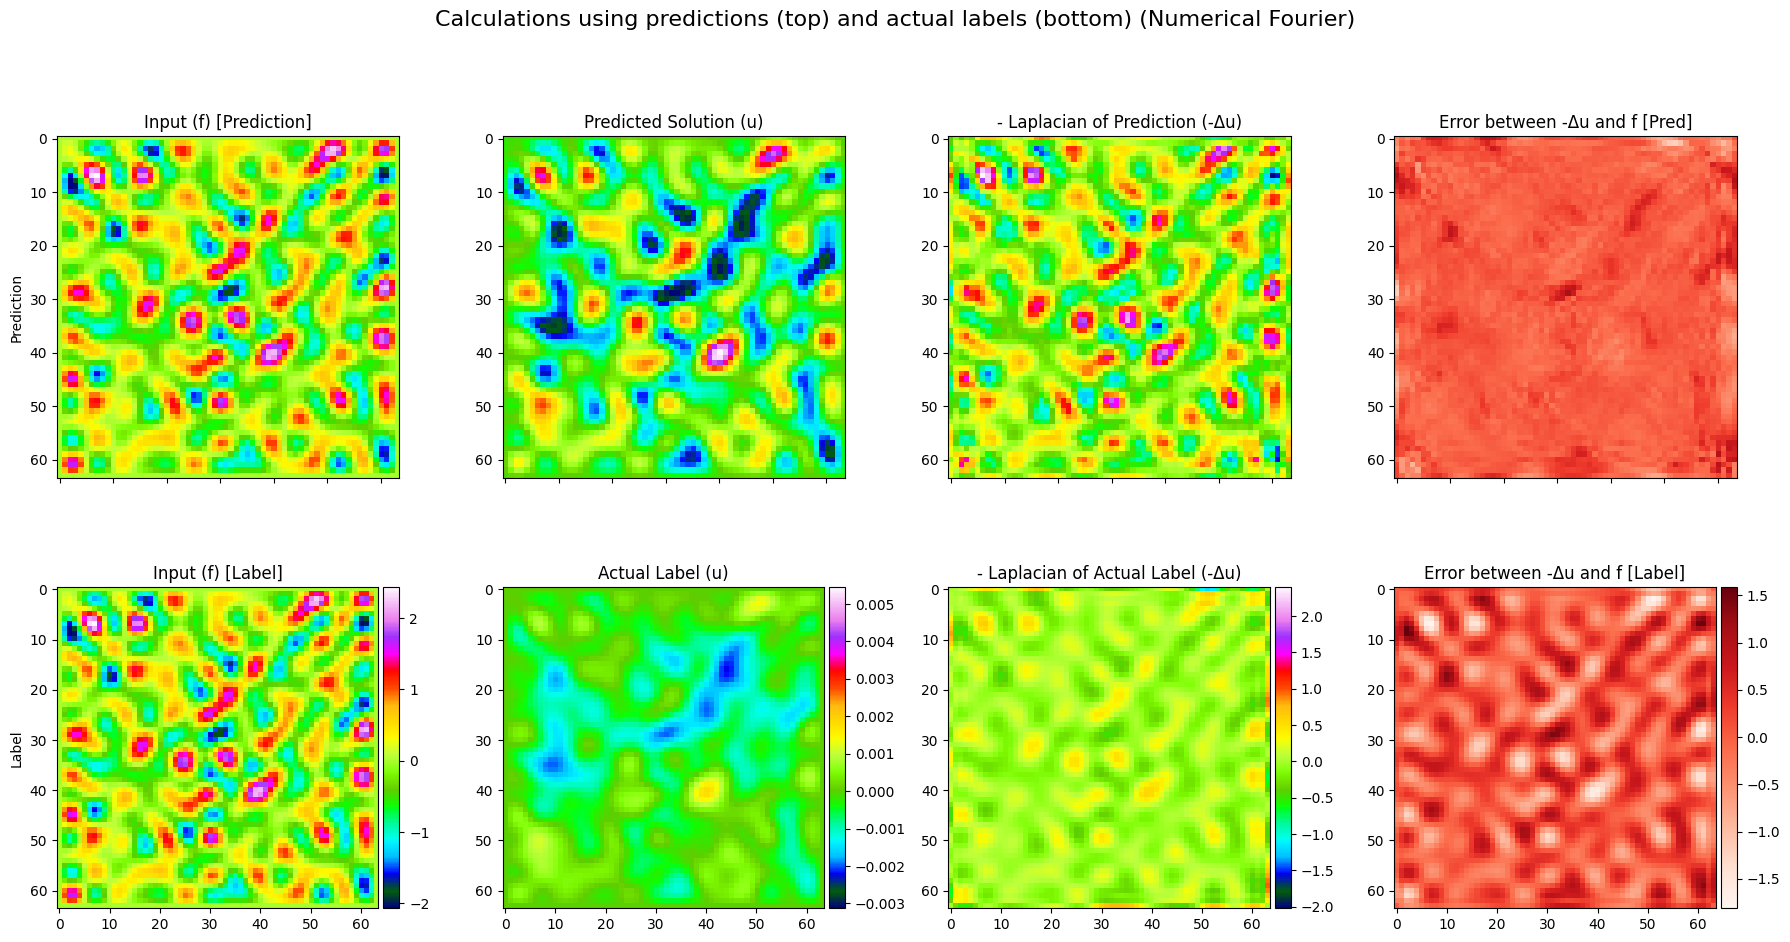

In [50]:
sample_idx = 0

""" Plot calculations using predictions and actual labels in a 2x4 grid with shared colorbars """

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle("Calculations using predictions (top) and actual labels (bottom) (Numerical Fourier)", fontsize=16)

# --- Prepare data ---
# Row 0: predictions
input_pred = input_un_sq[sample_idx].cpu().numpy()
pred_sol = output_pred_un_sq[sample_idx].cpu().numpy()
neg_lap_output = -laplacian_of_output[sample_idx].cpu().numpy()
error_output = neg_lap_output - input_pred

# Row 1: labels
input_label = input_un_sq[sample_idx].cpu().numpy()
actual_label = label_un_sq[sample_idx].cpu().numpy()
neg_lap_label = -laplacian_of_label[sample_idx].cpu().numpy()
error_label = neg_lap_label - input_label

# --- Plotting ---
# For columns 0-2, use the same vmin/vmax for both rows for consistent colorbars
vmin0 = min(input_pred.min(), input_label.min())
vmax0 = max(input_pred.max(), input_label.max())

vmin1 = min(pred_sol.min(), actual_label.min())
vmax1 = max(pred_sol.max(), actual_label.max())

vmin2 = min(neg_lap_output.min(), neg_lap_label.min())
vmax2 = max(neg_lap_output.max(), neg_lap_label.max())

vmin3 = min(error_output.min(), error_label.min())
vmax3 = max(error_output.max(), error_label.max())

# Column 0: Input (f)
im00 = axes[0,0].imshow(input_pred, cmap=cmap, vmin=vmin0, vmax=vmax0)
axes[0,0].set_title("Input (f) [Prediction]")
im10 = axes[1,0].imshow(input_label, cmap=cmap, vmin=vmin0, vmax=vmax0)
axes[1,0].set_title("Input (f) [Label]")

# Column 1: Solution (u)
im01 = axes[0,1].imshow(pred_sol, cmap=cmap, vmin=vmin1, vmax=vmax1)
axes[0,1].set_title("Predicted Solution (u)")
im11 = axes[1,1].imshow(actual_label, cmap=cmap, vmin=vmin1, vmax=vmax1)
axes[1,1].set_title("Actual Label (u)")

# Column 2: -Laplacian
im02 = axes[0,2].imshow(neg_lap_output, cmap=cmap, vmin=vmin2, vmax=vmax2)
axes[0,2].set_title("- Laplacian of Prediction (-Δu)")
im12 = axes[1,2].imshow(neg_lap_label, cmap=cmap, vmin=vmin2, vmax=vmax2)
axes[1,2].set_title("- Laplacian of Actual Label (-Δu)")

# Column 3: Error
im03 = axes[0,3].imshow(error_output, cmap='Reds', vmin=vmin3, vmax=vmax3)
axes[0,3].set_title("Error between -Δu and f [Pred]")
im13 = axes[1,3].imshow(error_label, cmap='Reds', vmin=vmin3, vmax=vmax3)
axes[1,3].set_title("Error between -Δu and f [Label]")

# --- Shared colorbars for each column ---
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_shared_colorbar(im_top, im_bottom, ax_top, ax_bottom, label=None):
    # Place colorbar to the right of the two axes
    divider = make_axes_locatable(ax_bottom)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im_bottom, cax=cax)
    if label:
        cb.set_label(label)
    # Remove ticklabels from top row for clarity
    ax_top.set_xticklabels([])
    ax_top.set_xlabel("")
    return cb

# For each column, add a single colorbar to the right of the bottom axis
add_shared_colorbar(im00, im10, axes[0,0], axes[1,0])
add_shared_colorbar(im01, im11, axes[0,1], axes[1,1])
add_shared_colorbar(im02, im12, axes[0,2], axes[1,2])
add_shared_colorbar(im03, im13, axes[0,3], axes[1,3])

# Set y-labels for rows
axes[0,0].set_ylabel("Prediction")
axes[1,0].set_ylabel("Label")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()